In [1]:
!pip install torchbearer

import torch
from torch import nn
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import ssl
import seaborn as sns
import time
import torchbearer

sns.set_theme()
ssl._create_default_https_context = ssl._create_unverified_context

     |████████████████████████████████| 138 kB 9.1 MB/s 


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters
num_epochs = 150
batch_size = 64
learning_rate = 0.01

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



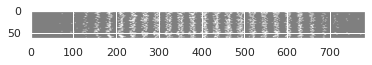

In [4]:
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [5]:
'''
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.covModule = nn.Sequential(
            #input a 3x32x32 image
            nn.Conv2d(3, 64, (5,5)),  #image size will be 64x28x28
            nn.MaxPool2d(2, 2),#image size will be 64x14x14
            nn.Conv2d(64, 64, (5,5)), #image size will be 64x10x10
            nn.MaxPool2d(2, 2), #image size will be 64x5x5
            nn.Conv2d(64, 128, (5,5)) #image size will be 64x1x1
            #nn.MaxPool2d(2, 2), #image size will be 128x1x1
        )
        self.fcModule = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            #nn.Softmax() #no need for softmax ans CrossEntropy loss already has it
        )
    def forward(self, x):
        x = self.covModule(x)
        x = x.view(-1, 1*1*128)
        output = self.fcModule(x)
        return output
'''



'\nclass ConvNet(nn.Module):\n    def __init__(self):\n        super(ConvNet, self).__init__()\n        self.covModule = nn.Sequential(\n            #input a 3x32x32 image\n            nn.Conv2d(3, 64, (5,5)),  #image size will be 64x28x28\n            nn.MaxPool2d(2, 2),#image size will be 64x14x14\n            nn.Conv2d(64, 64, (5,5)), #image size will be 64x10x10\n            nn.MaxPool2d(2, 2), #image size will be 64x5x5\n            nn.Conv2d(64, 128, (5,5)) #image size will be 64x1x1\n            #nn.MaxPool2d(2, 2), #image size will be 128x1x1\n        )\n        self.fcModule = nn.Sequential(\n            nn.Linear(128, 128),\n            nn.ReLU(),\n            nn.Dropout(0.5),\n            nn.Linear(128, 10),\n            #nn.Softmax() #no need for softmax ans CrossEntropy loss already has it\n        )\n    def forward(self, x):\n        x = self.covModule(x)\n        x = x.view(-1, 1*1*128)\n        output = self.fcModule(x)\n        return output\n'

In [6]:
class FCNClass(nn.Module):
    def __init__(self):
        # input: 784 Dimensional Vectors as input
        super(FCNClass, self).__init__()
        
        # layer 1 (784-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.layer1 = nn.Sequential(
                        nn.Linear(784, 100),
                        nn.ReLU(), 
                        nn.Dropout(p=0.5)
        )
        
        # Layer 2 (100-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.layer2 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(), 
                        nn.Dropout(p=0.5)
        )
        
        # Layer 3 (100-10)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.layer3 = nn.Sequential(
                        nn.Linear(100, 10),
                        nn.ReLU(), 
                        nn.Dropout(p=0.5)
        )

        # 10 softmax activated output neurons
        self.outputLayer = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        midLevel = self.layer1(x)
        midLevel = self.layer2(midLevel)
        midLevel = self.layer3(midLevel)
        output   = self.outputLayer(midLevel)
        return output

In [7]:
def plotLosses(epochs, Loss, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(epochs, Loss, label = "Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

In [9]:
#model = ConvNet().to(device)
model = FCNClass().to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, nesterov = True, momentum = 0.9)



Epoch [1/150], Step [200/938], Loss: 2.2968
Epoch [1/150], Step [400/938], Loss: 2.2971
Epoch [1/150], Step [600/938], Loss: 2.2690
Epoch [1/150], Step [800/938], Loss: 2.1514
Epoch [2/150], Step [200/938], Loss: 2.0900
Epoch [2/150], Step [400/938], Loss: 2.0326
Epoch [2/150], Step [600/938], Loss: 2.0575
Epoch [2/150], Step [800/938], Loss: 2.0190
Epoch [3/150], Step [200/938], Loss: 1.9855
Epoch [3/150], Step [400/938], Loss: 2.0417
Epoch [3/150], Step [600/938], Loss: 1.9865
Epoch [3/150], Step [800/938], Loss: 2.0319
Epoch [4/150], Step [200/938], Loss: 1.9840
Epoch [4/150], Step [400/938], Loss: 1.9934
Epoch [4/150], Step [600/938], Loss: 1.9345
Epoch [4/150], Step [800/938], Loss: 2.0243
Epoch [5/150], Step [200/938], Loss: 2.0287
Epoch [5/150], Step [400/938], Loss: 1.9406
Epoch [5/150], Step [600/938], Loss: 1.9336
Epoch [5/150], Step [800/938], Loss: 2.0035
Epoch [6/150], Step [200/938], Loss: 1.9774
Epoch [6/150], Step [400/938], Loss: 1.9346
Epoch [6/150], Step [600/938], L

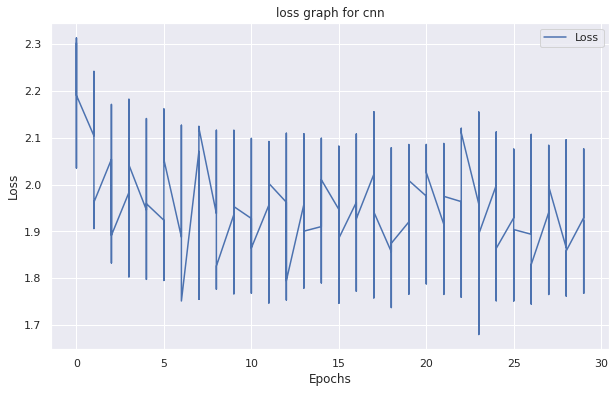

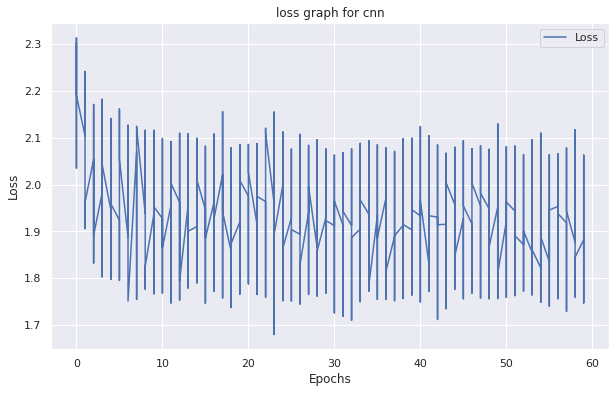

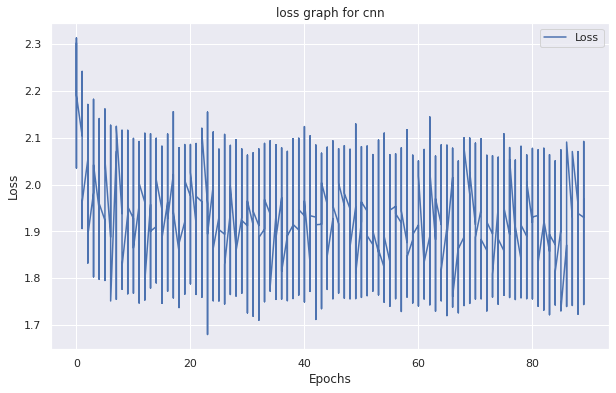

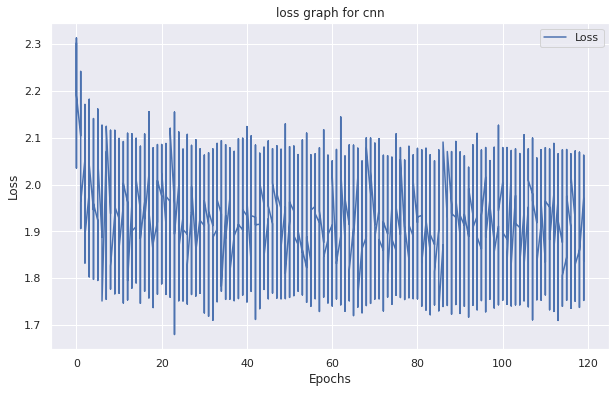

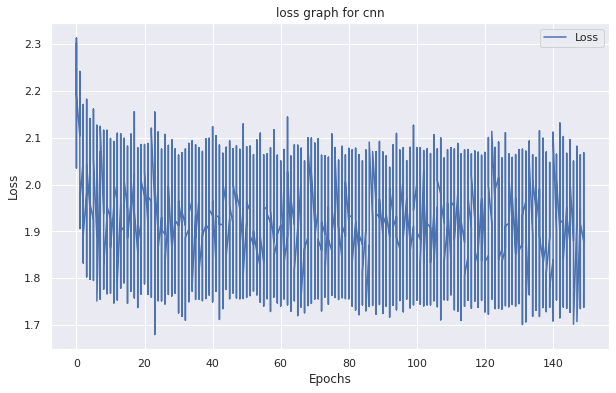

In [10]:
loss_history = []
epochs = []
n_total_steps = len(train_loader)
start_time = time.time()
for epoch in range(num_epochs):
    if epoch == 60:
        learning_rate = learning_rate/10
    if epoch == 120:
        learning_rate = learning_rate/10
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_history.append(loss.item())
        epochs.append(epoch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 200 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    if (epoch+1) % 30 == 0:
        plotLosses(epochs, loss_history, 'loss graph for cnn')

print("--- %s seconds ---" % (time.time() - start_time))

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

In [11]:

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 51.89 %
Accuracy of plane: 96.73469387755102 %
Accuracy of car: 46.69603524229075 %
Accuracy of bird: 48.44961240310077 %
Accuracy of cat: 47.722772277227726 %
Accuracy of deer: 46.537678207739305 %
Accuracy of dog: 45.85201793721973 %
Accuracy of frog: 46.45093945720251 %
Accuracy of horse: 47.17898832684825 %
Accuracy of ship: 47.43326488706366 %
Accuracy of truck: 46.6798810703667 %


In [12]:
X_train, y_train = next(iter(train_loader))
X_test, y_test = next(iter(test_loader))

In [13]:
trial = torchbearer.Trial(model, optimizer, criterion, metrics=['loss', 'accuracy', 'top_5_acc'])
trial.with_generators(train_loader, test_generator=test_loader)

trial.run(epochs=10)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)

0/10(t):   0%|          | 0/938 [00:00<?, ?it/s]

1/10(t):   0%|          | 0/938 [00:00<?, ?it/s]

2/10(t):   0%|          | 0/938 [00:00<?, ?it/s]

3/10(t):   0%|          | 0/938 [00:00<?, ?it/s]

4/10(t):   0%|          | 0/938 [00:00<?, ?it/s]

5/10(t):   0%|          | 0/938 [00:00<?, ?it/s]

6/10(t):   0%|          | 0/938 [00:00<?, ?it/s]

7/10(t):   0%|          | 0/938 [00:00<?, ?it/s]

8/10(t):   0%|          | 0/938 [00:00<?, ?it/s]

9/10(t):   0%|          | 0/938 [00:00<?, ?it/s]

0/1(e):   0%|          | 0/157 [00:00<?, ?it/s]

{'test_loss': 1.4998805522918701, 'test_acc': 0.9670000076293945, 'test_top_5_acc': 0.9927999973297119}


In [15]:
print(test_loader.items)

AttributeError: ignored

In [16]:
print(len(epochs))
print(len(loss_history))

140700
140700


938


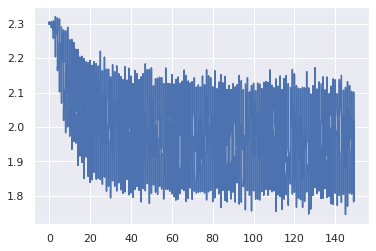

In [17]:
plt.plot(epochs,loss_history)
print(len(train_loader))